In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

### The dataset that we will use for this project will be the "Breast Cancer Wisconsin (Diagnostic) Data Set, and it deals with binary classification and includes features computed from digitized images of biopsies.  I will perform many types of models and select the one that gives us the best cross validated score, while balancing the performance time.  Also, I will provide classification reports, ROC curves and AUC scores for each respective model

In [2]:
column_names = ['SampleCode', 'ClumpThickness', 'UniformityCellSize', 'Uniformity_CellShape', 'MarginalAdhesion',
               'Single_Epi_CellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleolei', 'Mitosis', 'Class']

df = pd.read_csv('breast cancer wisconsin.csv', names=column_names)
df = df.drop_duplicates()
# = df.reset_index()
print(df.head())
print(df.shape)

   SampleCode  ClumpThickness  UniformityCellSize  Uniformity_CellShape  \
0     1000025               5                   1                     1   
1     1002945               5                   4                     4   
2     1015425               3                   1                     1   
3     1016277               6                   8                     8   
4     1017023               4                   1                     1   

   MarginalAdhesion  Single_Epi_CellSize BareNuclei  BlandChromatin  \
0                 1                    2          1               3   
1                 5                    7         10               3   
2                 1                    2          2               3   
3                 1                    3          4               3   
4                 3                    2          1               3   

   NormalNucleolei  Mitosis  Class  
0                1        1      2  
1                2        1      2  
2          

In [3]:
#replace strings with numbers
df['BareNuclei'] = df['BareNuclei'].str.replace('?', '1')
#print(df['BareNuclei'][:50])

#check to see if all values in series is numeric
#print(df['BareNuclei'][:50].str.isnumeric())

In [4]:
# Resampling our data to correct for imbalance in our class variable

# Class count, 2 represents benign, and 4 represents malignant
count_class_2, count_class_4 = df.Class.value_counts()
print(count_class_2)
print(count_class_4)
# Divide by class
df_class_2 = df[df['Class'] == 2]
df_class_4 = df[df['Class'] == 4]

453
238


Random under-sampling:
4    238
2    238
Name: Class, dtype: int64


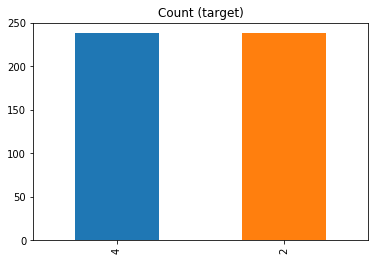

In [5]:
#extract the observations with class zero, equal to the number of obervations equal
df_class_2_under = df_class_2.sample(count_class_4)

#create a new dataframe with the same number of values for our two classes
new_df = pd.concat([df_class_2_under, df_class_4], axis=0)

print('Random under-sampling:')
print(new_df.Class.value_counts())

new_df.Class.value_counts().plot(kind='bar', title='Count (target)')

In [6]:
#check for any null spaces in our data
new_df.isnull().sum()

SampleCode              0
ClumpThickness          0
UniformityCellSize      0
Uniformity_CellShape    0
MarginalAdhesion        0
Single_Epi_CellSize     0
BareNuclei              0
BlandChromatin          0
NormalNucleolei         0
Mitosis                 0
Class                   0
dtype: int64

In [7]:
#split the data
X = new_df.drop(['Class', 'SampleCode'], 1)

#make the dependent 'class' variable binary
new_df['Class'] = np.where(new_df['Class'] > 2, 1, 0)

Y = new_df['Class']

print(X.shape)
print(Y.shape)
#print(Y)

(476, 9)
(476,)


AxesSubplot(0.125,0.125;0.62x0.755)


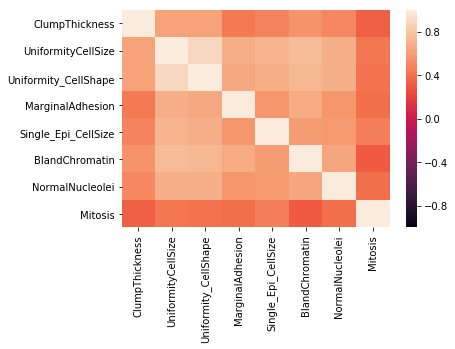

In [8]:
#Creating a heatmap to check for any correlation between our independent variables.
Xvar_heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1)

print(Xvar_heatmap)


#### From the heatmap above, we see that there is correlation between some of our independent variables.  Specifically the independent variables related to cell shape and cell size, such as Uniformity_CellShape, UniformityCellSize and Single_Epi_CellSize, have high correlations with each other.  This could be problematic for some of our models; for  example with Naive Bayes because of this model's assumption that all independent variables are completely independent of each other. 

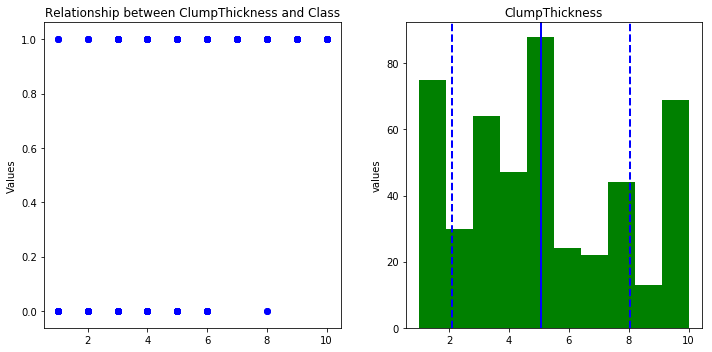

In [9]:
#column_names = ['SampleCode', 'ClumpThickness', 'UniformityCellSize', 'Uniformity_CellShape', 'MarginalAdhesion',
#               'Single_Epi_CellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleolei', 'Mitosis', 'Class']


#plotting the relationship between the independent and dependent variables, as well as the histograpsh of independent variables.
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['ClumpThickness'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between ClumpThickness and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['ClumpThickness'], color='green')
plt.axvline(new_df['ClumpThickness'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['ClumpThickness'].mean() + new_df['ClumpThickness'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['ClumpThickness'].mean()- new_df['ClumpThickness'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('ClumpThickness')

plt.tight_layout()
plt.show()

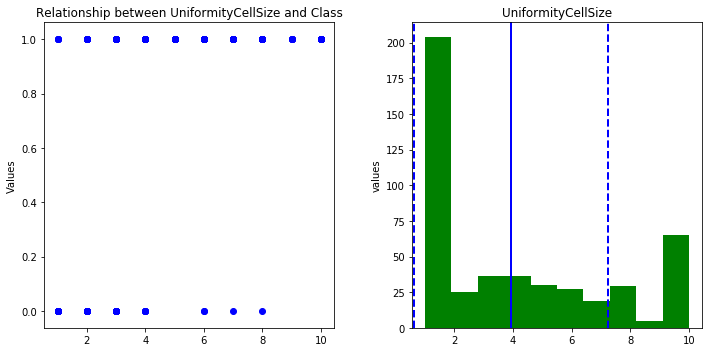

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['UniformityCellSize'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between UniformityCellSize and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['UniformityCellSize'], color='green')
plt.axvline(new_df['UniformityCellSize'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['UniformityCellSize'].mean() + new_df['UniformityCellSize'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['UniformityCellSize'].mean()- new_df['UniformityCellSize'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('UniformityCellSize')

plt.tight_layout()
plt.show()

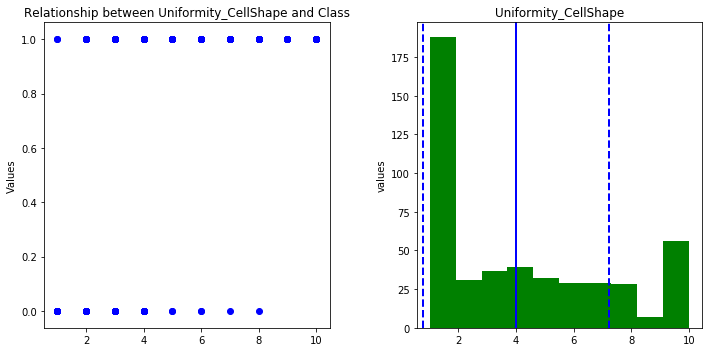

In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['Uniformity_CellShape'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between Uniformity_CellShape and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['Uniformity_CellShape'], color='green')
plt.axvline(new_df['Uniformity_CellShape'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['Uniformity_CellShape'].mean() + new_df['Uniformity_CellShape'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['Uniformity_CellShape'].mean()- new_df['Uniformity_CellShape'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('Uniformity_CellShape')

plt.tight_layout()
plt.show()

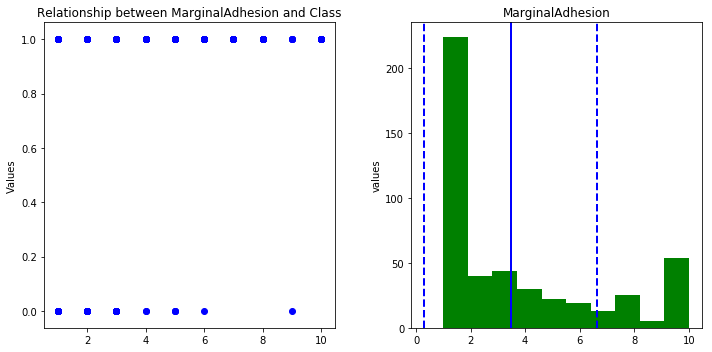

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['MarginalAdhesion'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between MarginalAdhesion and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['MarginalAdhesion'], color='green')
plt.axvline(new_df['MarginalAdhesion'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['MarginalAdhesion'].mean() + new_df['MarginalAdhesion'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['MarginalAdhesion'].mean()- new_df['MarginalAdhesion'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('MarginalAdhesion')

plt.tight_layout()
plt.show()

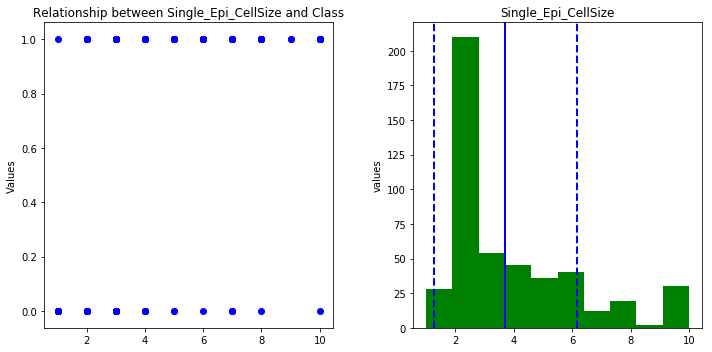

In [13]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['Single_Epi_CellSize'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between Single_Epi_CellSize and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['Single_Epi_CellSize'], color='green')
plt.axvline(new_df['Single_Epi_CellSize'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['Single_Epi_CellSize'].mean() + new_df['Single_Epi_CellSize'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['Single_Epi_CellSize'].mean()- new_df['Single_Epi_CellSize'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('Single_Epi_CellSize')

plt.tight_layout()
plt.show()

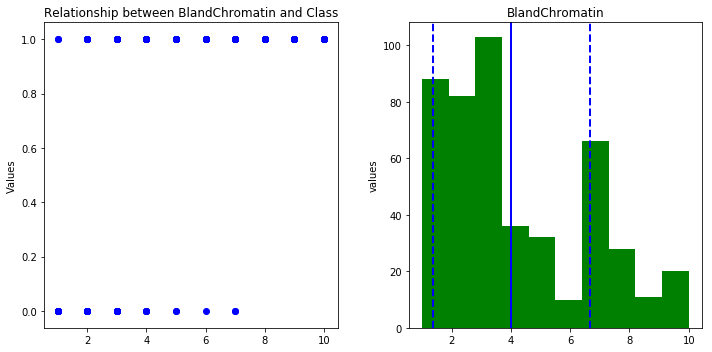

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['BlandChromatin'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between BlandChromatin and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['BlandChromatin'], color='green')
plt.axvline(new_df['BlandChromatin'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['BlandChromatin'].mean() + new_df['BlandChromatin'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['BlandChromatin'].mean()- new_df['BlandChromatin'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('BlandChromatin')

plt.tight_layout()
plt.show()

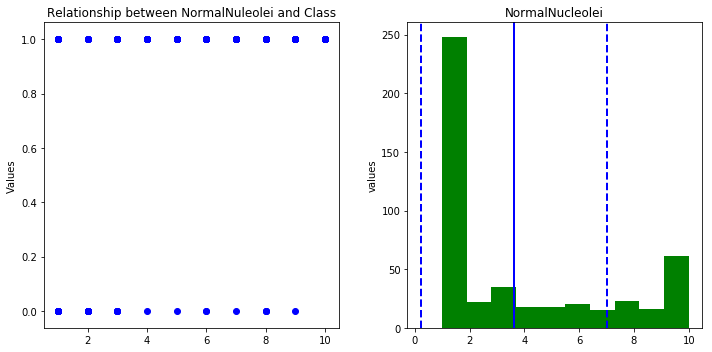

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['NormalNucleolei'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between NormalNuleolei and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['NormalNucleolei'], color='green')
plt.axvline(new_df['NormalNucleolei'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['NormalNucleolei'].mean() + new_df['NormalNucleolei'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['NormalNucleolei'].mean()- new_df['NormalNucleolei'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('NormalNucleolei')

plt.tight_layout()
plt.show()

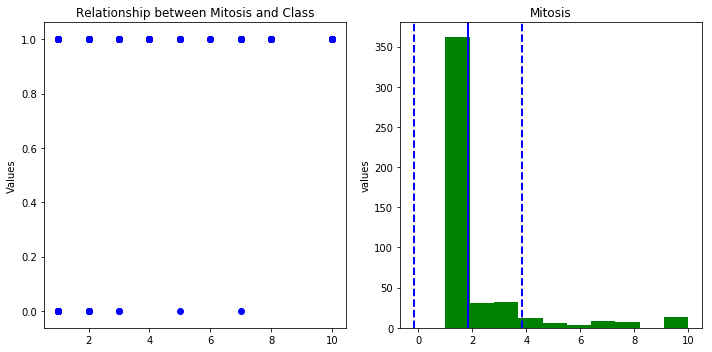

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x = new_df['Mitosis'], y = new_df['Class'], color='blue')
plt.ylabel('Values')
plt.title('Relationship between Mitosis and Class')

plt.subplot(1, 2, 2)
plt.hist(new_df['Mitosis'], color='green')
plt.axvline(new_df['Mitosis'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(new_df['Mitosis'].mean() + new_df['Mitosis'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(new_df['Mitosis'].mean()- new_df['Mitosis'].std(), color='b', linestyle='dashed', linewidth=2) 
plt.ylabel('values')
plt.title('Mitosis')

plt.tight_layout()
plt.show()

In [17]:
#sns.pairplot(X)
#X_grid = sns.PairGrid(X)
#X_grid = X_grid.map(plt.scatter)

#### I will attempt to deal with this multicollinearity using PCA, and separately also with SelectKBest.  I will then run each model using the full feature dataset, the PCA dataset with reduced dimensions, and the SelectKBest dataset with the reduced number of features, side by side so that I can give an accurate comparison.

In [18]:
#initial set of train and test groups, before applying SelectKBest and PCA.

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=.3, random_state=10)

# PCA:

In [19]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# o

X_scaled = StandardScaler().fit_transform(X)

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
#Apply PCA

pca = PCA(.95)
X_pca = pca.fit_transform(X_scaled)

comp_no = pca.n_components_
comp_var_ratio = pca.explained_variance_ratio_

print(comp_no)
print(comp_var_ratio)
#print(p_components)

7
[0.63022409 0.09067808 0.06429537 0.05753047 0.04527482 0.03708223
 0.03216931]


In [21]:
#pca data to dataframe
pca_df = pd.DataFrame(data=X_pca)
print(pca_df.head())
print(pca_df.shape)

          0         1         2         3         4         5         6
0 -1.819051 -0.030140  0.070461  0.232032  0.052560 -0.345572 -0.411743
1 -2.512913  0.225841  0.572867  0.026588  0.040350  0.056452 -0.231034
2 -1.900973 -0.103155 -0.474851 -0.059394 -0.234005 -0.575101  0.204803
3 -2.544308  0.267516  0.227921  0.042016  0.083695  0.083716  0.072843
4 -2.308768  0.130562  0.010619  0.057118  0.023043 -0.051952  0.003972
(476, 7)


In [22]:
#After applying PCA, I split the data into a second set of train and test groups

train_X_pca, test_X_pca, train_Y_pca, test_Y_pca = train_test_split(X_pca, Y, test_size=.3, random_state=20)

# SelectKBest:

In [ ]:
#performing GridsearchCV to get the best parameters for SelectKBest.
#Kbest = SelectKBest().fit_transform(X, Y)
#K_params = {'k':[1,2,3,4,5,6], 'score_func':[chi2, f_classif]}
#Kgrid = GridSearchCV(Kbest, K_params, cv=5, scoring='accuracy')
#Kgrid.fit(X, Y)
#print('Best parameters for SelectKBest:', Kgrid.best_params_)

In [23]:
#applying selectKBest.
X_skb = SelectKBest(f_classif, k=6).fit_transform(X, Y)
print(X_skb.shape)

(476, 6)


In [24]:
#After applying SelectKBest, I split the data into a third set of train and test groups
train_X_skb, test_X_skb, train_Y_skb, test_Y_skb = train_test_split(X_skb, Y, test_size=.3, random_state=20)

# Naive Bayes:

In [25]:
#Model using full dataset

# Instantiate our model and store it in a variable
bnb = BernoulliNB()

#set start time
start_time = datetime.datetime.now()

# Fit our model to the data.
bnb.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_bayes = bnb.predict(test_X)

#Run accuracy score
print('Accuracy score: ' + str(metrics.accuracy_score(test_Y, y_pred_bayes)))

#calculate end time
end_time = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time - start_time))
print()

#Use cross validation to gauge the accuracy of our model
Nbayes_cvs = cross_val_score(bnb, X, Y, cv=10, scoring='accuracy')
print(Nbayes_cvs)
print('Average cross validated score from our Naive Bayes model is: ' + str(np.mean(Nbayes_cvs)))


Accuracy score: 0.48951048951048953

Duration: 0:00:00.003232

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Average cross validated score from our Naive Bayes model is: 0.5


AUC Score: 0.500


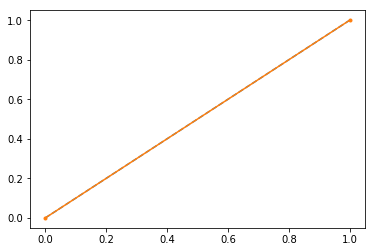

In [26]:
# predict probabilities
probs = bnb.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bayes_auc = roc_auc_score(test_Y, probs)
print('AUC Score: %.3f' % bayes_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_Y, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [27]:
#perform classification report of naive bayes model
class_names = ['Class_2_Benign', 'Class_4_Malignant']
bayes_report = classification_report(test_Y, y_pred_bayes, target_names=class_names)
print(bayes_report)

                   precision    recall  f1-score   support

   Class_2_Benign       0.00      0.00      0.00        73
Class_4_Malignant       0.49      1.00      0.66        70

        micro avg       0.49      0.49      0.49       143
        macro avg       0.24      0.50      0.33       143
     weighted avg       0.24      0.49      0.32       143



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
#create confusion matrix
confusion_matrix(test_Y, y_pred_bayes)

array([[ 0, 73],
       [ 0, 70]], dtype=int64)

### The Naive Bayes model does a poor job of predicting accurate class values.  According to the confusion matrix, the naive bayes model predicted just as many positives correctly, as it predicted negatives incorrectly.  This matches the AUC score of .5.  The ROC curve, AUC score, and the confusion matrix, combined tell us that this model was no better than just taking a random guess. 
### Naive Bayes gave a cross validated score of .5.  One reason for this could be, as we saw earlier, alot of our independent variables were highly correlated with one another.  An assumption of Naive Bayes to work properly is that the predictior variables have to be truly independent of each other.

### I will next perform the main tree based algorithm models, such as The Decision Tree, Random Forest, and MLP models, and give a short analysis after each model.

In [29]:
#Naive Bayes model using PCA

# Instantiate our model and store it in a variable
bnb_pca = BernoulliNB()

#set start time
start_time_pca = datetime.datetime.now()

# Fit our model to the data.
bnb_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
ypred_bayes_pca = bnb_pca.predict(test_X_pca)

#Run accuracy score
print('Accuracy score: ' + str(metrics.accuracy_score(test_Y_pca, ypred_bayes_pca)))

#calculate end time
end_time_pca = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_pca - start_time_pca))
print()

#Use cross validation to gauge the accuracy of our model
Nbayes_cvs_pca = cross_val_score(bnb_pca, X, Y, cv=5, scoring='accuracy')
print(Nbayes_cvs_pca)
print('Average cross validated score from our Naive Bayes model is: ' + str(np.mean(Nbayes_cvs_pca)))


Accuracy score: 0.9300699300699301

Duration: 0:00:00

[0.5 0.5 0.5 0.5 0.5]
Average cross validated score from our Naive Bayes model is: 0.5


### The Accuracy score of Naive Bayes improved dramatically using PCA, possibly because PCA utilized the main components that explained the majority of the variance in the data, and in the process took out some of the unnecessary correlated columns.  But the average cross validated score was still a disappointing .5, suggesting there might be overfitting

AUC Score: 0.965


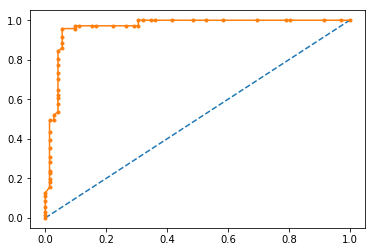

In [30]:
# predict probabilities
probs_pca = bnb_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_pca = probs_pca[:, 1]
# calculate AUC
bayes_auc_pca = roc_auc_score(test_Y_pca, probs_pca)
print('AUC Score: %.3f' % bayes_auc_pca)
# calculate roc curve
fpr_pca, tpr_pca, thresholds = roc_curve(test_Y_pca, probs_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_pca, tpr_pca, marker='.')
# show the plot
plt.show()

In [31]:
#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
bayes_report_pca = classification_report(test_Y_pca, ypred_bayes_pca, target_names=class_names)
print(bayes_report_pca)

                   precision    recall  f1-score   support

   Class_2_Benign       0.96      0.90      0.93        72
Class_4_Malignant       0.91      0.96      0.93        71

        micro avg       0.93      0.93      0.93       143
        macro avg       0.93      0.93      0.93       143
     weighted avg       0.93      0.93      0.93       143



In [32]:
#create confusion matrix for naive bayes model after pca
confusion_matrix(test_Y_pca, ypred_bayes_pca)

array([[65,  7],
       [ 3, 68]], dtype=int64)

In [33]:
#Naive Bayes model using SelectKbest

# Instantiate our model and store it in a variable
bnb_skb = BernoulliNB()

#set start time
start_time_skb = datetime.datetime.now()

# Fit our model to the data.
bnb_skb.fit(train_X_skb, train_Y_skb)

# Classify, storing the result in a new variable.
ypred_bayes_skb = bnb_skb.predict(test_X_skb)

#Run accuracy score
print('Accuracy score: ' + str(metrics.accuracy_score(test_Y_skb, ypred_bayes_skb)))

#calculate end time
end_time_skb = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_skb - start_time_skb))
print()

#Use cross validation to gauge the accuracy of our model
Nbayes_cvs_skb = cross_val_score(bnb_skb, X, Y, cv=5, scoring='accuracy')
print(Nbayes_cvs_skb)
print('Average cross validated score from our Naive Bayes model is: ' + str(np.mean(Nbayes_cvs_skb)))


Accuracy score: 0.4965034965034965

Duration: 0:00:00.005266

[0.5 0.5 0.5 0.5 0.5]
Average cross validated score from our Naive Bayes model is: 0.5


AUC Score: 0.500


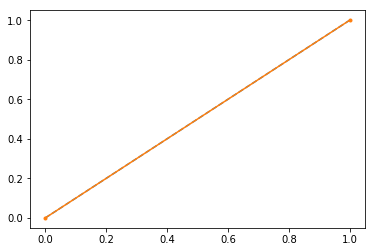

In [34]:
# predict probabilities
probs_skb = bnb_skb.predict_proba(test_X_skb)
# keep probabilities for the positive outcome only
probs_skb = probs_skb[:, 1]
# calculate AUC
bayes_auc_skb = roc_auc_score(test_Y_skb, probs_skb)
print('AUC Score: %.3f' % bayes_auc_skb)
# calculate roc curve
fpr_skb, tpr_skb, thresholds = roc_curve(test_Y_skb, probs_skb)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_skb, tpr_skb, marker='.')
# show the plot
plt.show()

In [35]:
#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
bayes_report_skb = classification_report(test_Y_skb, ypred_bayes_skb, target_names=class_names)
print(bayes_report_skb)

                   precision    recall  f1-score   support

   Class_2_Benign       0.00      0.00      0.00        72
Class_4_Malignant       0.50      1.00      0.66        71

        micro avg       0.50      0.50      0.50       143
        macro avg       0.25      0.50      0.33       143
     weighted avg       0.25      0.50      0.33       143



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
#create confusion matrix for naive bayes model after selectKbest
confusion_matrix(test_Y_skb, ypred_bayes_skb)

array([[ 0, 72],
       [ 0, 71]], dtype=int64)

# Decision Tree

In [37]:
# perform grid search to find the optimal parameters for our decision tree model, using the full dataset.
dtree = tree.DecisionTreeClassifier(random_state=2)
tree_param_grid = {'max_depth':[2,4,6], 'min_samples_split':[2,5,8], 'max_features':[2,4,6], 'criterion':['entropy', 'gini']}
dtree_grid = GridSearchCV(dtree, tree_param_grid, cv=5)
dtree_grid.fit(train_X, train_Y)
print('Best parameters for decision tree:', dtree_grid.best_params_)

Best parameters for decision tree: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 2, 'min_samples_split': 2}


C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
# Initialize and train our tree on the full dataset.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=4,
    max_depth=4,
    min_samples_split=5,
    random_state = 2
)

#set start time
start_time_tree = datetime.datetime.now()

#train our tree
decision_tree.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_dtree = decision_tree.predict(test_X)

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y, y_pred_dtree)))

#calculate end time
end_time_tree = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_tree - start_time_tree))
print()

#get accuracy score of decision tree
tree_score = cross_val_score(decision_tree, X, Y, cv=5, scoring='accuracy')
print(tree_score)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score)))

Accuracy score for decision tree Model: 0.9440559440559441

Duration: 0:00:00.005630

[0.91666667 0.9375     0.95833333 0.9787234  0.94680851]
Average cross validated score from our decision tree model is: 0.9476063829787235


AUC Score: 0.973


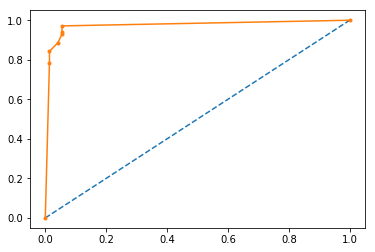

In [39]:
#Get AUC and create ROC for decision tree with full data
# predict probabilities
probs_dtree = decision_tree.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_dtree = probs_dtree[:, 1]
# calculate AUC
dtree_auc = roc_auc_score(test_Y, probs_dtree)
print('AUC Score: %.3f' % dtree_auc)
# calculate roc curve
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(test_Y, probs_dtree)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dtree, tpr_dtree, marker='.')
# show the plot
plt.show()

In [40]:
#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
tree_report = classification_report(test_Y, y_pred_dtree, target_names=class_names)
print(tree_report)

                   precision    recall  f1-score   support

   Class_2_Benign       0.95      0.95      0.95        73
Class_4_Malignant       0.94      0.94      0.94        70

        micro avg       0.94      0.94      0.94       143
        macro avg       0.94      0.94      0.94       143
     weighted avg       0.94      0.94      0.94       143



In [41]:
#create confusion matrix for naive bayes model after selectKbest
confusion_matrix(test_Y, y_pred_dtree)

array([[69,  4],
       [ 4, 66]], dtype=int64)

In [42]:
#GridsearchCV with PCA
dtree_pca = tree.DecisionTreeClassifier(random_state=4)
tree_param_grid_pca = {'max_depth':[2,4,6,8], 'min_samples_split':[2,5,8,10], 'max_features':[2,4,6], 
                       'criterion':['entropy', 'gini']}
dtree_grid_pca = GridSearchCV(dtree_pca, tree_param_grid_pca, cv=5)
dtree_grid_pca.fit(train_X_pca, train_Y_pca)
print('Best parameters for decision tree:', dtree_grid_pca.best_params_)

Best parameters for decision tree: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 2, 'min_samples_split': 2}


C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [43]:
# Initialize and train the tree using PCA.
decision_tree_pca = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=2,
    min_samples_split=2,
    random_state = 4
)

#set start time
start_time_treePca = datetime.datetime.now()

#train our tree
decision_tree_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
ypred_dtree_pca = decision_tree_pca.predict(test_X_pca)

#get accuracy score from our model
print('Accuracy score for decision tree Model after using PCA: ' + str(metrics.accuracy_score(test_Y_pca, ypred_dtree_pca)))

#calculate end time
end_time_treePca = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_treePca - start_time_treePca))
print()

#get accuracy score of decision tree
tree_score_pca = cross_val_score(decision_tree_pca, X, Y, cv=5, scoring='accuracy')
print(tree_score_pca)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score_pca)))

Accuracy score for decision tree Model after using PCA: 0.958041958041958

Duration: 0:00:00.002434

[0.89583333 0.91666667 0.90625    0.9893617  0.91489362]
Average cross validated score from our decision tree model is: 0.9246010638297874


AUC Score: 0.968


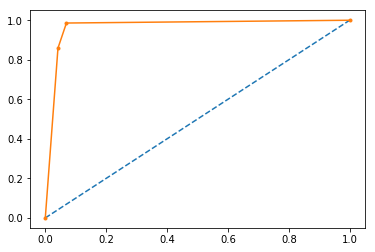

In [44]:
#Get AUC and create ROC for decision tree with PCA
# predict probabilities
probs_dtree_pca = decision_tree_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_dtree_pca = probs_dtree_pca[:, 1]
# calculate AUC
dtree_auc_pca = roc_auc_score(test_Y_pca, probs_dtree_pca)
print('AUC Score: %.3f' % dtree_auc_pca)
# calculate roc curve
fpr_dtree_pca, tpr_dtree_pca, thresholds_dtree_pca = roc_curve(test_Y_pca, probs_dtree_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dtree_pca, tpr_dtree_pca, marker='.')
# show the plot
plt.show()

In [45]:
#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
tree_report_pca = classification_report(test_Y_pca, ypred_dtree_pca, target_names=class_names)
print(tree_report_pca)

                   precision    recall  f1-score   support

   Class_2_Benign       0.99      0.93      0.96        72
Class_4_Malignant       0.93      0.99      0.96        71

        micro avg       0.96      0.96      0.96       143
        macro avg       0.96      0.96      0.96       143
     weighted avg       0.96      0.96      0.96       143



In [46]:
#create confusion matrix for naive bayes model after PCA
confusion_matrix(test_Y_pca, ypred_dtree_pca)

array([[67,  5],
       [ 1, 70]], dtype=int64)

In [47]:
#GridsearchCV with selectkbest

dtree_skb = tree.DecisionTreeClassifier(random_state=6)
tree_param_grid_skb = {'max_depth':[2,4,6,8], 'min_samples_split':[2,5,8,10], 'max_features':[2,4,6], 
                       'criterion':['entropy', 'gini']}
dtree_grid_skb = GridSearchCV(dtree_skb, tree_param_grid_skb, cv=5)
dtree_grid_skb.fit(train_X_skb, train_Y_skb)
print('Best parameters for decision tree:', dtree_grid_skb.best_params_)

Best parameters for decision tree: {'criterion': 'gini', 'max_depth': 6, 'max_features': 2, 'min_samples_split': 10}


C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [48]:
# Initialize and train the tree using SelectKBest.
decision_tree_skb = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=2,
    max_depth=6,
    min_samples_split=8,
    random_state = 6
)

#set start time
start_time_treeSkb = datetime.datetime.now()

#train our tree
decision_tree_skb.fit(train_X_skb, train_Y_skb)

# Classify, storing the result in a new variable.
ypred_dtree_skb = decision_tree_skb.predict(test_X_skb)

#get accuracy score from our model
print('Accuracy score for decision tree Model with SelectKBest: ' + str(metrics.accuracy_score(test_Y, ypred_dtree_skb)))

#calculate end time
end_time_treeSkb = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_treeSkb - start_time_treeSkb))
print()

#get accuracy score of decision tree
tree_score_skb = cross_val_score(decision_tree_skb, X, Y, cv=5, scoring='accuracy')
print(tree_score_skb)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score_skb)))

Accuracy score for decision tree Model with SelectKBest: 0.45454545454545453

Duration: 0:00:00.002331

[0.875      0.91666667 0.92708333 0.9787234  0.91489362]
Average cross validated score from our decision tree model is: 0.9224734042553191


AUC Score: 0.970


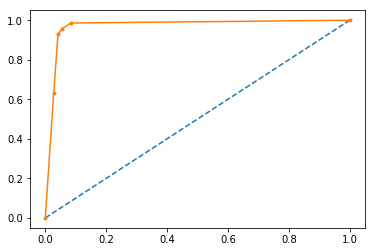

                   precision    recall  f1-score   support

   Class_2_Benign       0.96      0.94      0.95        72
Class_4_Malignant       0.94      0.96      0.95        71

        micro avg       0.95      0.95      0.95       143
        macro avg       0.95      0.95      0.95       143
     weighted avg       0.95      0.95      0.95       143

Confusion Matrix:


array([[68,  4],
       [ 3, 68]], dtype=int64)

In [49]:
#Get AUC and create ROC for decision tree with SelectKBest
# predict probabilities
probs_dtree_skb = decision_tree_skb.predict_proba(test_X_skb)
# keep probabilities for the positive outcome only
probs_dtree_skb = probs_dtree_skb[:, 1]
# calculate AUC
dtree_auc_skb = roc_auc_score(test_Y_skb, probs_dtree_skb)
print('AUC Score: %.3f' % dtree_auc_skb)
# calculate roc curve
fpr_dtree_skb, tpr_dtree_skb, thresholds_dtree_skb = roc_curve(test_Y_skb, probs_dtree_skb)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dtree_skb, tpr_dtree_skb, marker='.')
# show the plot
plt.show()

#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
tree_report_skb = classification_report(test_Y_skb, ypred_dtree_skb, target_names=class_names)
print(tree_report_skb)

#create confusion matrix for naive bayes model after selectKbest
print('Confusion Matrix:')
confusion_matrix(test_Y_skb, ypred_dtree_skb)


### The Decision Tree model performed alot better than the the Naive Bayes Model.  The cross validated scores for the three types of decision tree models that we built (using full data, using PCA, and using SelectKBest)  all were in the range of 93-95%.  This could be due to the fact that the decision tree model, along with the other tree based algorithms such as random forest and gradient boosting, work well with independent variables that have a dependence with, or are correlated with, each other.

### Tree based algorithms also work well with data in which the predictor (independent) variables don't have a linear relationship with the output (dependent) variables; as is the case with our dataset here.

# Random Forest

In [51]:
#initialize and train our random forest model with full data.
rand_forest = ensemble.RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=4, max_features=2,
                                              min_samples_split=5, random_state=20)

#set start time
start_time_rforest = datetime.datetime.now()

rand_forest.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_rforest = rand_forest.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y, y_pred_rforest)))

#calculate end time
end_time_rforest = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_rforest - start_time_rforest))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs = cross_val_score(rand_forest, X, Y, cv=5, scoring='accuracy')
print(rforest_cvs)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_cvs)))

Accuracy score for Random Forest Model: 0.9790209790209791

Duration: 0:00:00.054982

[0.96875    0.94791667 0.97916667 0.9893617  1.        ]
Average cross validated score from our Random Forest Model is: 0.9770390070921986


AUC Score: 0.995


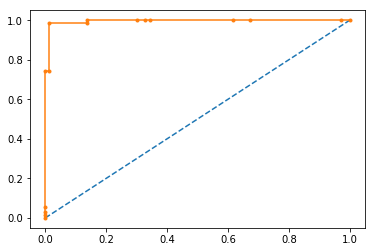

                   precision    recall  f1-score   support

   Class_2_Benign       0.97      0.99      0.98        73
Class_4_Malignant       0.99      0.97      0.98        70

        micro avg       0.98      0.98      0.98       143
        macro avg       0.98      0.98      0.98       143
     weighted avg       0.98      0.98      0.98       143

Confusion Matrix:


array([[72,  1],
       [ 2, 68]], dtype=int64)

In [52]:
#Get AUC and create ROC for decision tree with full data
# predict probabilities
probs_rforest = rand_forest.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_rforest = probs_rforest[:, 1]
# calculate AUC
rforest_auc = roc_auc_score(test_Y, probs_rforest)
print('AUC Score: %.3f' % rforest_auc)
# calculate roc curve
fpr_rforest, tpr_rforest, thresholds_rforest = roc_curve(test_Y, probs_rforest)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rforest, tpr_rforest, marker='.')
# show the plot
plt.show()

#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
rforest_report = classification_report(test_Y, y_pred_rforest, target_names=class_names)
print(rforest_report)

#create confusion matrix for naive bayes model after selectKbest
print('Confusion Matrix:')
confusion_matrix(test_Y, y_pred_rforest)

In [ ]:
#using gridsearchcv with our random forest model and PCA
# perform grid search to find the optimal parameters for our random forest model, using the full dataset.
rforest_pca = ensemble.RandomForestClassifier(random_state=20)
forest_param_grid_pca = {'n_estimators':[10,20,50,100], 'max_depth':[2,4,6,8], 'min_samples_split':[2,5,8,10], 
                     'max_features':[2,4,6,7], 'criterion':['entropy', 'gini']}
rforest_grid_pca = GridSearchCV(rforest_pca, forest_param_grid_pca, cv=5)
rforest_grid_pca.fit(train_X_pca, train_Y_pca)
print('Best parameters for decision tree:', rforest_grid_pca.best_params_)

In [53]:
#initialize and train our random forest model with pca
rand_forest_pca = ensemble.RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=2, max_features=2,
                                              min_samples_split=2, random_state=20)

#set start time
start_time_rforest_pca = datetime.datetime.now()

rand_forest_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
ypred_rforest_pca = rand_forest_pca.predict(test_X_pca)

#get accuracy score from our model
print('Accuracy score for Random Forest Model using PCA is: ' + str(metrics.accuracy_score(test_Y_pca, ypred_rforest_pca)))

#calculate end time
end_time_rforest_pca = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_rforest_pca - start_time_rforest_pca))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs_pca = cross_val_score(rand_forest_pca, X, Y, cv=5, scoring='accuracy')
print(rforest_cvs_pca)
print('Average cross validated score from our Random Forest Model using PCA is: ' + str(np.mean(rforest_cvs_pca)))

Accuracy score for Random Forest Model using PCA is: 0.958041958041958

Duration: 0:00:00.010786

[0.95833333 0.9375     0.96875    0.9893617  0.9893617 ]
Average cross validated score from our Random Forest Model using PCA is: 0.9686613475177305


AUC Score: 0.975


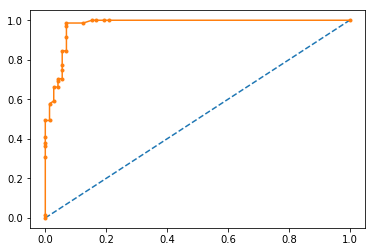

                   precision    recall  f1-score   support

   Class_2_Benign       0.99      0.93      0.96        72
Class_4_Malignant       0.93      0.99      0.96        71

        micro avg       0.96      0.96      0.96       143
        macro avg       0.96      0.96      0.96       143
     weighted avg       0.96      0.96      0.96       143

Confusion Matrix:


array([[67,  5],
       [ 1, 70]], dtype=int64)

In [54]:
#Get AUC and create ROC for random forest with PCA
# predict probabilities
probs_rforest_pca = rand_forest_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_rforest_pca = probs_rforest_pca[:, 1]
# calculate AUC
rforest_auc_pca = roc_auc_score(test_Y_pca, probs_rforest_pca)
print('AUC Score: %.3f' % rforest_auc_pca)
# calculate roc curve
fpr_rforest_pca, tpr_rforest_pca, thresholds_rforest_pca = roc_curve(test_Y_pca, probs_rforest_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rforest_pca, tpr_rforest_pca, marker='.')
# show the plot
plt.show()

#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
rforest_report_pca = classification_report(test_Y_pca, ypred_rforest_pca, target_names=class_names)
print(rforest_report_pca)

#create confusion matrix for naive bayes model after selectKbest
print('Confusion Matrix:')
confusion_matrix(test_Y_pca, ypred_rforest_pca)

In [ ]:
#using gridsearchcv with our random forest model and selectKbest
rforest_skb = ensemble.RandomForestClassifier(random_state=57)
forest_param_grid_skb = {'n_estimators':[10,20,50,100], 'max_depth':[2,4,6,8], 'min_samples_split':[2,5,8,10], 
                     'max_features':[2,4,6], 'criterion':['entropy', 'gini']}
rforest_grid_skb = GridSearchCV(rforest_skb, forest_param_grid_skb, cv=5)
rforest_grid_skb.fit(train_X_skb, train_Y_skb)
print('Best parameters for decision tree:', rforest_grid_skb.best_params_)

In [55]:
#initialize and train our random forest model with selectkbest
rand_forest_skb = ensemble.RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4, max_features=2,
                                              min_samples_split=2, random_state=57)

#set start time
start_time_rforest_skb = datetime.datetime.now()

rand_forest_skb.fit(train_X_skb, train_Y_skb)

# Classify, storing the result in a new variable.
ypred_rforest_skb = rand_forest_skb.predict(test_X_skb)

#get accuracy score from our model
print('Accuracy score for Random Forest Model using SelectKBest is: ' + str(metrics.accuracy_score(test_Y_pca, ypred_rforest_skb)))

#calculate end time
end_time_rforest_skb = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_rforest_skb - start_time_rforest_skb))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs_skb = cross_val_score(rand_forest_skb, X, Y, cv=5, scoring='accuracy')
print(rforest_cvs_skb)
print('Average cross validated score from our Random Forest Model using SelectKBest is: ' + str(np.mean(rforest_cvs_skb)))

Accuracy score for Random Forest Model using SelectKBest is: 0.958041958041958

Duration: 0:00:00.018212

[0.94791667 0.9375     0.97916667 0.96808511 1.        ]
Average cross validated score from our Random Forest Model using SelectKBest is: 0.9665336879432622


AUC Score: 0.982


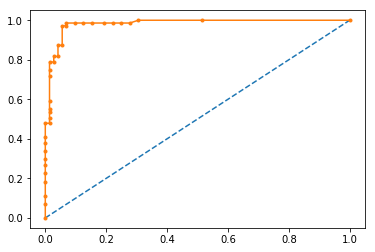

                   precision    recall  f1-score   support

   Class_2_Benign       0.99      0.93      0.96        72
Class_4_Malignant       0.93      0.99      0.96        71

        micro avg       0.96      0.96      0.96       143
        macro avg       0.96      0.96      0.96       143
     weighted avg       0.96      0.96      0.96       143

Confusion Matrix:


array([[67,  5],
       [ 1, 70]], dtype=int64)

In [56]:
#Get AUC and create ROC for random forest with SelectKBest
# predict probabilities
probs_rforest_skb = rand_forest_skb.predict_proba(test_X_skb)
# keep probabilities for the positive outcome only
probs_rforest_skb = probs_rforest_skb[:, 1]
# calculate AUC
rforest_auc_skb = roc_auc_score(test_Y_skb, probs_rforest_skb)
print('AUC Score: %.3f' % rforest_auc_skb)
# calculate roc curve
fpr_rforest_skb, tpr_rforest_skb, thresholds_rforest_skb = roc_curve(test_Y_skb, probs_rforest_skb)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rforest_skb, tpr_rforest_skb, marker='.')
# show the plot
plt.show()

#perform classification report of naive bayes model after PCA
class_names = ['Class_2_Benign', 'Class_4_Malignant']
rforest_report_skb = classification_report(test_Y_skb, ypred_rforest_skb, target_names=class_names)
print(rforest_report_skb)

#create confusion matrix for naive bayes model after selectKbest
print('Confusion Matrix:')
confusion_matrix(test_Y_skb, ypred_rforest_skb)

### The Random Forest Models, as expected, worked even better than the Decision Tree models.  This is because Random Forests, being one of the major ensemble modeling alogorithms, create many decision trees that are each based on a different subset of the dataset.  Then The decision trees within the random forest vote on the final output, and the majority class wins.  This is called bagging, and the idea of this is that the combination of learning from many tree models (versus one in a regular decision tree algorithm) increases the overall result.

### This could explain the higher average cross validated score of 98% from the random forest models, versus scores that fell in the range of 93-95% with the regular decision tree models.

## MLP Neural Network

In [57]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(train_X, train_Y)

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [58]:
#accuracy score for MLP model
mlp.score(test_X, test_Y)

0.965034965034965

In [59]:
#cross valiating MLP model
cross_val_score(mlp, X, Y, cv=5)

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

array([0.91666667, 0.94791667, 0.96875   , 0.9893617 , 0.9893617 ])

# Conclusion

For the particular dataset that we have here with its specfic issues, such as the correlation among the indepedent variables and the non-linear relationship between the independent and dependent variables, using one of the tree based models such as Random Forest is not a bad option.  Using Random Forest with the full data gave an accuracy score of about 97%.

With the MLP, I also got an accuracy score of 97%.  Using cross validation with the MLP model gave a slight hint of overfitting, although most of the scores in the 94-98% range.